# Credit Risk Resampling Techniques

In [334]:
import warnings
warnings.filterwarnings('ignore')

In [335]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

# Read the CSV and Perform Basic Data Cleaning

In [336]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [337]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


In [338]:
not_float = df.dtypes[df.dtypes != 'float64']
not_float

home_ownership          object
verification_status     object
issue_d                 object
loan_status             object
pymnt_plan              object
initial_list_status     object
next_pymnt_d            object
application_type        object
hardship_flag           object
debt_settlement_flag    object
dtype: object

In [339]:
#which columns are not numbers? dummy them
df_encoded = pd.get_dummies(df,columns=[x for x in not_float.index])
#Check for not float columns again and convert them to float 
not_float = [x for x in df_encoded.dtypes[df_encoded.dtypes != 'float64'].index]
print(not_float)
df_encoded[not_float] = df_encoded[not_float].astype('float64')
df_encoded.dtypes

['home_ownership_ANY', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'issue_d_Feb-2019', 'issue_d_Jan-2019', 'issue_d_Mar-2019', 'loan_status_high_risk', 'loan_status_low_risk', 'pymnt_plan_n', 'initial_list_status_f', 'initial_list_status_w', 'next_pymnt_d_Apr-2019', 'next_pymnt_d_May-2019', 'application_type_Individual', 'application_type_Joint App', 'hardship_flag_N', 'debt_settlement_flag_N']


loan_amnt                      float64
int_rate                       float64
installment                    float64
annual_inc                     float64
dti                            float64
                                ...   
next_pymnt_d_May-2019          float64
application_type_Individual    float64
application_type_Joint App     float64
hardship_flag_N                float64
debt_settlement_flag_N         float64
Length: 97, dtype: object

In [340]:
df_encoded[["loan_status_high_risk",'loan_status_low_risk']].head()

,loan_status_high_risk,loan_status_low_risk
0,0.0,1.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


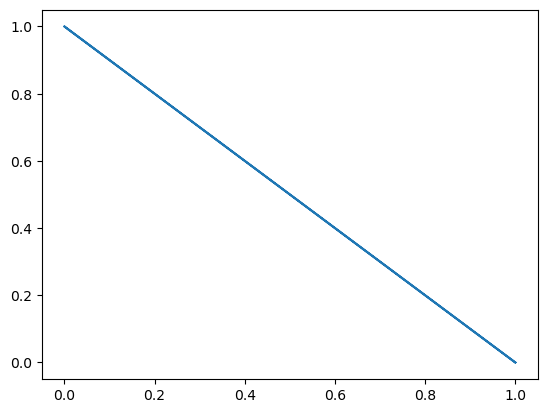

In [341]:
import matplotlib.pyplot as plt
plt.plot(df_encoded["loan_status_low_risk"],df_encoded["loan_status_high_risk"])
plt.show()

In [342]:
#since loan_status_high_risk are anticorrelated, we only need one of them. So I am going to drop the low_risk.
df_encoded.drop(columns="loan_status_low_risk",inplace=True)
# To keep it consistant, I am changing the name of loan_status_high_risk to loan_status
df_encoded.rename(columns={"loan_status_high_risk":"loan_status"},inplace=True)
df_encoded.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med', 'policy_code',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m',
       'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il',
       'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc',
       'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_in

# Split the Data into Training and Testing

In [343]:
# Create our features
X = df_encoded.drop(columns='loan_status')

# Create our target
y = pd.DataFrame(df_encoded['loan_status'])

In [344]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [345]:
# Check the balance of our target values
df['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [346]:
y["loan_status"].value_counts()

0.0    68470
1.0      347
Name: loan_status, dtype: int64

In [347]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1)

In [348]:
# NOte: With standard and minmax scaling, I got 100% accuracy!!!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier.fit(X_train_scaled, y_train)
y_pred = classifier.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.6038142313997537

In [349]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      1.00      0.21      1.00      0.46      0.22     17104
        1.0       0.81      0.21      1.00      0.33      0.46      0.19       101

avg / total       0.99      1.00      0.21      0.99      0.46      0.22     17205



# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [357]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [358]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier

LogisticRegression(random_state=1)

In [359]:
classifier.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [360]:
y_pred = classifier.predict(X_test_scaled)

In [361]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_test, y_pred)

0.8325760750771054

In [362]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[14425,  2679],
       [   18,    83]], dtype=int64)

In [363]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.84      0.82      0.91      0.83      0.69     17104
        1.0       0.03      0.82      0.84      0.06      0.83      0.69       101

avg / total       0.99      0.84      0.82      0.91      0.83      0.69     17205



### SMOTE Oversampling

In [364]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train_scaled, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [365]:
# Train the Logistic Regression model using the resampled data
classifier = LogisticRegression(random_state=1)
classifier

LogisticRegression(random_state=1)

In [367]:
classifier.fit(X_resampled, y_resampled)
y_pred = classifier.predict(X_test_scaled)

In [368]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8388510243681058

In [369]:
# Display the confusion matrix
confusion_matrix(y_test,y_pred)

array([[14809,  2295],
       [   19,    82]], dtype=int64)

In [370]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.87      0.81      0.93      0.84      0.71     17104
        1.0       0.03      0.81      0.87      0.07      0.84      0.70       101

avg / total       0.99      0.87      0.81      0.92      0.84      0.71     17205



# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [371]:
# Resample the data using the ClusterCentroids resampler
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=1)
X_resampled, y_resampled = cc.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [372]:
# Train the Logistic Regression model using the resampled data
classifier = LogisticRegression(random_state=1)
classifier

LogisticRegression(random_state=1)

In [373]:
classifier.fit(X_resampled,y_resampled)
y_pred = classifier.predict(X_test_scaled)

In [374]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8125920403078661

In [375]:
# Display the confusion matrix
confusion_matrix(y_test,y_pred)

array([[13064,  4040],
       [   14,    87]], dtype=int64)

In [376]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.76      0.86      0.87      0.81      0.65     17104
        1.0       0.02      0.86      0.76      0.04      0.81      0.66       101

avg / total       0.99      0.76      0.86      0.86      0.81      0.65     17205



# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [377]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_scaled, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [378]:
# Train the Logistic Regression model using the resampled data
classifier = LogisticRegression(random_state=1)
classifier

LogisticRegression(random_state=1)

In [379]:
classifier.fit(X_resampled,y_resampled)
y_pred = classifier.predict(X_test_scaled)

In [380]:
# Calculated the balanced accuracy score
balanced_accuracy_score(y_test, y_pred)

0.8486452129777992

In [381]:
# Display the confusion matrix
confusion_matrix(y_test,y_pred)

array([[14636,  2468],
       [   16,    85]], dtype=int64)

In [382]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.86      0.84      0.92      0.85      0.72     17104
        1.0       0.03      0.84      0.86      0.06      0.85      0.72       101

avg / total       0.99      0.86      0.84      0.92      0.85      0.72     17205

